<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/temperature_forecasting_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 03rd Feb, 2023
# My folder: /home/ashok/Documents/14.sensor_data
# VM: lubuntu_deeplearning_I.vdi
# Ref: Page 207, Chapter 6, Deep Learning with Python by Fracois Chollete
# Download dataset from:
# 1. Link to my google drive
#  https://drive.google.com/file/d/1rnhlFKmmmhXqawaIBgjSTsqGrTLCUldV/view?usp=sharing
# 2. Link to original datasource
#  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [ ]:
# Objectives:
#             i)  Working with timeseries data
#             i)  Working with sensor data
#                 (Data comes from many sensors)
#             ii) Processing data to make it fit for modeling
#            iii) Creating data generator(s) for training and validation
#            iv)  Making predictions using
#                   a) Fully connected dense model
#                   b) GRU model
#                   c) GRU model with dropouts
#                   d) Stacked GRU models
#                   e) Bidirectional RNN layer
#
#

## Task

In [ ]:
# We will predict temperature:
# Sensor data is recorded every 10 minutes. So per-day we have:
#   no of minutes:              24 * 60     =  1440
#   no of 10 minutes interval: (24 * 60)/10 = 144 datapoints/per day
#   no of data-points in 10 days: 1440

In [ ]:
#   Our Data
#   This is the data from csv file in notepad++
#   Note each col-header is a string
#   but each col value is NOT. 
#   First col is date-time

"""

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60

"""

## Call libraries

In [ ]:
# 1.0 Reset all variables
#%reset -f

# 1.0 Call libraries:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import os, time, gc, pathlib

In [ ]:
# 1.0.1 Display multiple outputs from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Mount gdrive

In [ ]:
# 1.1 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## How to read csv data without pandas
Read csv file. First split at '\n', then at ',' and finally create numpy array.<br>
`
>open(path)<br>
>f.read()<br>
>f.close()<br>
>data.split('\n')<br>
>lines.split(',')<br>
`

In [ ]:
# 1.1 Where is my data folder?
data_dir = '/gdrive/MyDrive/Colab_data_files/jena'

# 1.1.0 Make data_dir a pathlib object:

folderPath = pathlib.Path(data_dir)

In [ ]:
# 1.2 Join datapath with filename (intelligently)
#     If you are on Windows, assign to fname full
#     data path+ filename:

fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
fname

'/gdrive/MyDrive/Colab_data_files/jena/jena_climate_2009_2016.csv'

In [ ]:
# 1.2 Get filename:

fname = folderPath / 'jena_climate_2009_2016.csv'

In [ ]:
# 1.3 Read datafile, line by line
# 1.3.1 First get a handle to file:

f = open(fname)   # open() default mode is text+read

# 1.3.2 Use handle to read complete file
data = f.read()

In [ ]:
# 1.3.3 Close read file:

f.close()

## Observe read file data
Basic python operations on file

In [ ]:
# 1.3.4 Check data type:
#       It is one string:

assert type(data) is str

print("\n====\n")

type(data) #  str


====



str

In [ ]:
# 1.3.5 Observe Ist 220 chars of data string:
#       Also see '\n' char in between:

data[0:220]      # Whole data is read as one string
                 # Read first 200 characters of string
                 # Note '\n' at 196th character


'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"\n01.01.2009 00:10:00,996.'

In [ ]:
# 1.4 Process string:

# 1.4.1 Split data on newline (\n). So how many records?

lines = data.split('\n')    # Split data 'str' at every 'newline'
                            # and collect the str(s) in a list
print("\n=====\n")

type(lines)                 # list =>  All splits are in one list
print("\n=====\n")
len(lines)                  # Total splits/elements are 420552
print("\n=====\n")
lines[3]                    # Just print some element of list




=====



list


=====



420552


=====



'01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60'

In [ ]:
# 1.4.2 Does any header exist? Check:
lines[0]                   # yes, it does

print("\n=====\n")

lines[1]                  # Contains data

'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"'


=====



'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [ ]:
# 1.4.3 Extract header (field-names)
header = lines[0].split(',')  # Split at each ','

header  # A list of strs AND within each string is a string

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [ ]:
# 1.4.4 How many columns/fields?

cols = len(header)
cols             # 15

15

In [ ]:
# 1.4.5 Print first three rows.
#       Note 10-minute gap in the
#       observations:

lines[1:4]     # A list of 3 string elements

print("\n======\n")

len(lines)    # 420552 or header + 420551 data points

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']

420552

In [ ]:
# 1.4.6 Total samples?

totalsamples = len(lines) - 1    # 420551 (exclude header)
totalsamples

420551

## Populating numpy array with data
Transform our `lines` to numpy array<br>
`
>`create zero-filled array`<br>
` for ith line in lines`<br>
>>  fill $i^{th}$ np.array() with i.split(',')<br>
`

In [ ]:
# 2.0 Convert all 420551 data points into a numpy array
#     for processing

# 2.1 First create a zero-valued 2D-array
#      While creating zero-valued 2D-array, forget
#        first column or time col
#     So array size will be same as that of data

float_data = np.zeros(
                       (totalsamples, cols -1 )   # Exclude 1st date/time col
                      )  

float_data.shape           # (420551,14)

(420551, 14)

In [ ]:
# 2.2 Fill this 2D-zero-valued array, row-by-row using for-loop
# 2.2.1 First get an array of 420551 values
#       0 ,1, 2, 3,...420550

numbList=np.arange(float_data.shape[0])
numbList

array([     0,      1,      2, ..., 420548, 420549, 420550])

In [ ]:
# 2.2.2 See how a line is split in respective
#       field values. We want split values to
#       be an array. But after the split,
#       they are a list

x = lines[1].split(',')
type(x)      # list

list

In [ ]:
# 2.2.3 Transform x, a list, into numpy array:
#

x = np.asarray(
               x[1:],     # list
               dtype = 'float32'
               ) # Exclude 1st date/time column

type(x)
print("\n======\n")
x
print("\n======\n")
x.shape

numpy.ndarray

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02], dtype=float32)

(14,)

In [ ]:
# 2.3  Fill up zero-array,row-by-row, with sensor data
for i in numbList:      # ie uptil the last line
    
    # 2.3.0 Now do this for all lines using for-loop
    row_list = lines[i+1].split(',')     # i starts from 0 but we ignore header

    # 2.3.1 'row' is a list. Select all but 1st element
    row_list= row_list[1:]                    # Ignore the date column
    
    # 2.3.2
    values = np.asarray(row_list, dtype = 'float32')
    
    # 2.3.3
    float_data[i, :] = values       # Fill zero-array, row-by-row

In [ ]:
# 2.3.4 Check
float_data.shape     # (420551,14)

print("\n======\n")

# 2.3.5
float_data[0]

(420551, 14)

array([ 9.96520020e+02, -8.02000046e+00,  2.65399994e+02, -8.89999962e+00,
        9.33000031e+01,  3.32999992e+00,  3.10999990e+00,  2.19999999e-01,
        1.94000006e+00,  3.11999989e+00,  1.30775000e+03,  1.02999997e+00,
        1.75000000e+00,  1.52300003e+02])

## Plotting temperature

In [ ]:
# 3. Let us plot temperature, the IInd column
#    Check 'header', if you like
# 3.1 Get IInd column with index 1
temp = float_data[:, 1]
temp

array([-8.02000046, -8.40999985, -8.51000023, ..., -3.16000009,
       -4.23000002, -4.82000017])

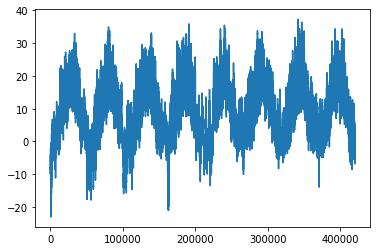

In [ ]:
# 3.2 plot it. It is highly periodic
plt.plot(range(len(temp)), temp) ;
plt.show() ; 

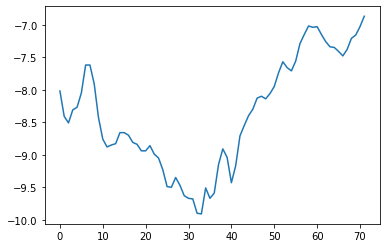

In [ ]:
# 3.3 Let us see 12-hour variation
#     How many readings in one-day?  (24 * 60 )/10 = 144
#     So half day = 72 points
#     It is half of this variation we want to predict

plt.plot(range((12*60//10)), temp[:72]) ;
plt.show() ; 

In [ ]:
# 3.4 Delete unwanted variable
del temp
gc.collect()

4879

## Standardize data

In [ ]:
### Data pre-processing
###---------------
# 4.0 For processing we center and scale all data
#     Could have used sklearn's StandardScaler()
#     We decide upon a max sample size of 2 lakh
#     Were we rich in memory, more could have been selected

training_data_size = 420551     # select 200000 to save memory

In [ ]:
# 4.1   Get column-wise (axis= 0) mean
#       We extract mean from training data only but would apply
#       to whole of data

mean = float_data[:training_data_size].mean(axis = 0)
mean[:4]     # Show means of Ist four column means


array([989.21277606,   9.45014735, 283.49274343,   4.95585384])

In [ ]:
# 4.2  Subtract from each column, its respective mean
#      We subtract this from all data.

float_data = float_data - mean


In [ ]:
# 4.3   Get std deviation of each column 
#       but from training data only:

std = float_data[:training_data_size].std(axis = 0)
std[:4]    # First four column std deviation

array([8.35847079, 8.4233552 , 8.50446129, 6.73066631])

In [ ]:
# 4.4 Divide each column by its respective std deviation:

float_data /= std
float_data.shape

(420551, 14)

## Create data generators
Explanation

In [ ]:
################## Learning to create data generators ###############
##################### Expt & explanation #############################
## 5.0 Problem defined:
## --------------------
## Starting from any point, say, i, in dataset, our intention is
##  to lookback 1440 timesteps (24*60/10=144/day; 10days) behind,  
##   and using this data, predict temp one day ahead of i ie 144 
##    time steps ahead of i.
##    Instead of considering all 1440 lookback points, we will sample
##     one point per hour or just 240 datapoints for 10 days (24 * 10)
##      at hourly interval. 
##


In [ ]:
## Train Data Generator
## ---------------------
## 5.1 Case 1: How will we generate our training data?
##  Pick any random index, i, and then we will generate 
##    our data. Let us randomly pick i as: 302:
##        Batch 1 (240 observations)
##                (14 attributes + target)
##    obs   pressure     temp    humidity        Target
##    302     0.87        0.1     0.23             0.17
##    303     0.28        0.91    0.77             0.63
##    304     0.56        0.33    0.99             0.45
##    305       ..           ..      ..
##           ..           ..      ..
##    541     0.86        0.09    0.13             0.21
##    last point: i + 240 -1

##  5.1.1 Per epoch, we will pick 128 random indices (i(s)) & then generate
##         128 batches of data (steps_per_epoch = 128). Our data generator
##          can generate infinite batches of data, epoch-after-epoch.
##

In [ ]:
##  5.1.2 We will have heve 128 batches of (each batch: 240 X 14) datasets. 
##        For training data, all our 128 batches will be picked up randomly
##        from first 2 lakh data points. We select some arbitrary points
##        (arbitrary Xs) within our data and proceed sequentially to pick up
#         240 rows.

In [ ]:
##  5.1.3 We will make random selection of 128 points many
##        times (infinitely) in our training-data-generator (steps_per_epoch).
##        This will help in changing the sequence of time steps.

In [ ]:
##  5.1.4 Here is exactly how a batch is created for training:
##        ------------------------------------------------------
##        Starting from any point between row 1440 (24 * 6 * 10 days) 
##        till last row that is 200000th row, we make some random selection
##        of 128 numbers. Say, one number is 20451. From this number we look back
##        at all the data 1440 timesteps behind that is we start from index of
##        i - lookback -1 = 20451 - 1440 -1  = 19010. And start picking up, every 6th point. 
##        This will make us available 1440/6 = 240 observations.
##        And we want to predict temperature 'delay' ahead. So our target
##        value for this 2D data will be temperature reading, at row: 20451 + delay.

In [ ]:
## 5.2 Validation data Generator
## -----------------------------
##  For validation data, we start with min_index = 200001 and limit max_index = 300000.
##  This time we will NOT pick up batches randomly but sequentially. We start with 
##   200001 + lookback = 200001 + 1440 = 2001441 and get 128 row-numbers 
##     (including 2001441) sequentially that is: 201441, 201442,...201568 
##       ie upto (200001 + 1440 +128 - 1) OR (i + lookback -1 + batch_size ).
##        While proceeding throgh these numbers, one by one, we prepare dataset of 
##         240 points (each point at an interval of 6steps). 

In [ ]:
## 5.3 Test Data generator
##  ----------------------------------------------
#  Same as for validation but this time min_index = 300001 
#   but max_index = None that is upto: len(float_data) - delay - 1.

## Constants

In [ ]:
# 6.0. Define some common constants:
#      timestep : 10 mins

lookback = 1440  # timesteps. (same as 10 days) In RNN, we will lookback at
                 #            1440 timesteps. Each timestep is 10 minutes.
# 6.1
step = 6         # Sample after every 'step' timesteps. 
                 # Per hour we pick one sample
                 # And not every 10 minutes that is pick one point after
                 #   every 6th point.
                 # Per lookback period datapoints will be 1440/6 = 240
                 # So our prediction will be based on data of size 240 X 14.
# 6.2
delay = 144      # timesteps. (same as 24 hours) We will forecast for a temperatue
                 # 144 timesteps ahead

# 6.3
batch_size = 128 # Analyse 'dataset' in batches of 128 considering memory limitations
                 # So we will analyse in memory at a time: 128 X 240 X 14

## Train data generator--demo

In [ ]:
#############################
###### Case 1   Constants for training data generator
#############################

# Define constants specific to this Case that is training data
# 7.0.
min_index = 0        # For training, we start from here
max_index = 200000   # Our last index-point for training (200001st pt)
shuffle = True       # Training batches will be picked up randomly

### Generate just a batch of pts (128)

In [ ]:
##******************************************************
#  Begin creating batches of datasets--One batch only
##******************************************************
#           float_data:10 (index: 9),
#                delay:6
# Therefore, max_index:3  (=9-6)
#        OR, (10 - 1 - 6) 


# 7.1 Our 'i' should be between min_index and max_index.
if max_index is None:    
    max_index = len(float_data) - delay - 1   # (200000 - 1) - 144 = 199855

# 7.1.1
max_index

200000

In [ ]:
# 7.2 And from where to begin creating lookback batches:

i = min_index + lookback     # Begin here to pick up earlier points
i                            # Start index


1440

In [ ]:
# 7.3

i      # 1440 timesteps to start with or 10 days lookback
       # If this is time, t, RNN gets data for t-1,
       #  t-2, right upto first point as lookback is 1440 timesteps
       # np.random.randint(low, high, howmany)
       # np.random.randint(0,100,10)   Gives 10 random points

1440

In [ ]:
# 7.4  How to get one set of 128 index-pts 
#        from where to lookback and pick up data of 240 X 14

if shuffle:               # For training only
    # Generate 128 random points (is) for picking training datasets

    #                             1440              199855           128
    rows = np.random.randint(min_index + lookback, max_index, size=batch_size) 

else:                      # for validation/test datasets
    # Else, generate 128 sequential points:
    if i + batch_size >= max_index:   # Given some 'i', if it exceeds limit
        i = min_index + lookback      #  then set it to min possible
    
    rows = np.arange(i, min(i + batch_size, max_index))  # Get a list of all
                                                         #  points from i uptill the limit
    i += len(rows)      # Increment i by batch_size (128). 
                        # Next batch pick-up pt is 128 ahead

In [ ]:
# 7.5 Have a look at rows from where to 
#      start picking up 240 lookback points:

rows
print("\n=====\n")

min(rows)    # min index
print("\n=====\n")

max(rows)    # max index

print("\n=====\n")
len(rows)    # 128 points

array([ 88072, 140010, 173667, 116106,  75729, 193854, 130499,  36595,
        22045,  65868, 121932, 119400, 166410, 109561,  35064, 124112,
       192847,  53029, 181101,  52936, 144309,  37406,  79462,  26932,
       129915, 167989, 130965,  15477, 198760, 181138, 130700, 174466,
       168104,  96491, 197601, 186770,  49296,  45984, 126433,  29255,
         4417,  70516, 101500,  31114,  48560, 107692, 143948,  11710,
       150921,   4168, 106760,  29251,  40748,  27463, 155521,  28660,
         2554, 131727,   6778,  60754, 130035,  74256,  18039, 134718,
        69620, 107370, 182866, 161666,  27978,   5274,  99574, 165828,
        88852,  32775, 167538, 139846, 181404,  97494, 112207,  50304,
       161633,  65252,  88821, 179376, 149797, 151680, 174809, 179378,
         1966, 118864,  76460,  89141,  67453, 129138, 182429, 123962,
        46540, 184347,  81788, 191249, 122961, 179218,  91861,   8287,
        63997, 194274, 148953,  50027, 161734,  49570, 184843,  78034,
      


=====



1966


=====



198760


=====



128

In [ ]:
# 7.6 Given row-points, get samples of datasets, each of 240 X 14
#     First, get an array of zeros of requistie batch size:

#  3D array          
samples = np.zeros(
                    (len(rows),             # 128
                     lookback // step,      # 240
                     float_data.shape[-1])  # 14
                    )



# 7.7 Check
samples.shape   # (128,240,14) (batch size, no_of_points_per_hour, attributes)


(128, 240, 14)

### Generate a batch of targets for 128 pts

In [ ]:
# 8.0 There will be as many targets as there are batches:
targets = np.zeros((len(rows),))
targets = np.zeros((128,))     # same as above
targets
print("\n==========\n")
len(targets)    # 128

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

128

In [ ]:
# 8.1 Prepare to fill in first batch 
#     into our 3D zero-array

j = 0                 # Later we can loop on this 'j'
row = rows[j]         # First point of 128 set taken above
row

88072

In [ ]:
# 8.2 Our prediction datapoint is 'delay' timesteps ahead
#     And in the data, temperature is at index 1

targets[j] = float_data[rows[j] + delay][1]   # Taregt value is the value in IInd column

# 8.3                                         #  at the end of rows[j] + delay
targets[j]

0.7467158003234955

### Fill in data for each one of 128 batch-pts
Go `lookup` pts behind and move ahead by `step`

In [ ]:
# 8.4 Whereever I am standing (say at, 1000), I go behind
#     'lookback' timesteps (say 100). From there, I proceed
#      forward, every 6-datapoints upto where I am standing
#       (ie upto 1000). So I collect 240 datapoints:
#        Try: indicies = list(range(1000-100, 1000, 6))

In [ ]:
#  8.5 Get indices of those 240 datapoints at intervals of 6 (step)
#      beginning from  jth index of rows[j]

indices = range(rows[j] - lookback, rows[j], step)   # 1440 timesteps values but in steps of 6
indices   # range(195492, 196932, 6)


range(86632, 88072, 6)

In [ ]:
# 8.6
print("\n=========\n")
len(indices)      # total: 240 points
print("\n=========\n")
list(indices)     # What are the points. Spaced at interval of 6

In [ ]:
# 8.7 Finally, fill our zero-sample with data at these indicies:

samples[j] = float_data[indices]          # 240 points
samples[j].shape                          # 240 X 14
print("\n========\n")

# 8.8 Just have a look
samples[j]

(240, 14)

array([[-9.21552098e-01,  1.41034686e+00,  1.47890189e+00, ...,
         1.61624219e-02,  3.33751088e-02,  1.09892149e+00],
       [-8.65325222e-01,  1.36285989e+00,  1.42598705e+00, ...,
         3.34283990e-02,  4.38073409e-02,  9.67405743e-01],
       [-7.77983707e-01,  1.23939354e+00,  1.29664246e+00, ...,
         1.78431790e-02,  4.72847561e-02,  1.14160659e+00],
       ...,
       [ 5.73936768e-01,  6.46993049e-01,  5.95834816e-01, ...,
         2.22742731e-02,  3.04772616e-02, -1.28024576e+00],
       [ 5.34453817e-01,  7.91828592e-01,  7.42816496e-01, ...,
        -4.77066321e-03,  1.49883437e-03, -1.87483570e+00],
       [ 5.04544040e-01,  9.37851111e-01,  8.89798175e-01, ...,
         2.25796448e-03,  1.30902060e-02, -1.56831156e+00]])

## Validation data generator--demo

In [ ]:
#############################
###### Case 2   Validation data generator
#############################

In [ ]:
# 9. We will have min_index = 200001 and max_index = 300000 and shuffle = False
#    Other constants remain same:

min_index = 200001
max_index = 300000
shuffle = False

In [ ]:
# 9.1   We have to get 128 consecutive points from where to pickup
#       128 batches of 240 X 14

# 9.1.1 Start here:

i = min_index + lookback     # Outside while 1

if shuffle:
    rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
else:
    # 9.1.2 Set i
    if i + batch_size >= max_index:  # If unable to get list of 128 points ahead
                                     #   to get 128 batches of (240 X 14)
        i = min_index + lookback     #  start afresh. min_index for validation is 200001
    
    # 9.1.3
    rows = np.arange(i,
                     min(i + batch_size, max_index)
                     )  # Get a list of all 128 points from i upto limit
                                                         
   # 9.3.4 Advance i by 128 pts
    i += len(rows)                     # Advance i by 128 steps to get next 128 batches

In [ ]:
# 10
i              # Next batch begins at: 200001 + 1440 + 128 = 201569
print("\n===========\n")
len(rows)                    # 128
print("\n===========\n")
rows           # Just list them

201569

128

array([201441, 201442, 201443, 201444, 201445, 201446, 201447, 201448,
       201449, 201450, 201451, 201452, 201453, 201454, 201455, 201456,
       201457, 201458, 201459, 201460, 201461, 201462, 201463, 201464,
       201465, 201466, 201467, 201468, 201469, 201470, 201471, 201472,
       201473, 201474, 201475, 201476, 201477, 201478, 201479, 201480,
       201481, 201482, 201483, 201484, 201485, 201486, 201487, 201488,
       201489, 201490, 201491, 201492, 201493, 201494, 201495, 201496,
       201497, 201498, 201499, 201500, 201501, 201502, 201503, 201504,
       201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512,
       201513, 201514, 201515, 201516, 201517, 201518, 201519, 201520,
       201521, 201522, 201523, 201524, 201525, 201526, 201527, 201528,
       201529, 201530, 201531, 201532, 201533, 201534, 201535, 201536,
       201537, 201538, 201539, 201540, 201541, 201542, 201543, 201544,
       201545, 201546, 201547, 201548, 201549, 201550, 201551, 201552,
      

In [ ]:
# 11. Get a zero-filled array of 128 X 240 X 14
#     Now get
#     
samples = np.zeros(
                    (len(rows),              # 128
                     lookback // step,       # 240
                     float_data.shape[-1])   # 14
                    )


# 11.0.1
samples.shape   # (128,240,14) (batch size, no_of_points_per_hour, attributes)

(128, 240, 14)

In [ ]:
# 11.1 There will be as many targets as there are batches:

targets = np.zeros((len(rows),))
targets
len(targets)    # 128

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

128

In [ ]:
# 12. Fill the batch with data:

row = rows[0]    # First data point to start first batch from
j = 0
row              # 201441

201441

In [ ]:
# 12.1 Whereever I am standing, I go loopback back
#      From there, I proceed forward, every 6-datapoints
#      So I collect 240 datapoints
#  Get indices of those 240 datapoints

#                    200001          201441   6
indices = range(rows[j] - lookback, rows[j], step)   # 1440 timesteps values but in steps of 6
print("\n============\n")
indices   # rrange(200001, 201441, 6)
print("\n============\n")
len(indices)      # total: 240 points

range(200001, 201441, 6)

240

In [ ]:
# 12.2
samples[j] = float_data[indices]          # 240 points
samples[j].shape                          # 240 X 14

(240, 14)

In [ ]:
# 12.3
samples[j]

array([[ 2.12046670e-02,  5.05719228e-01,  5.00590975e-01, ...,
         8.36981378e-03,  4.39667468e-03,  3.74430818e-01],
       [ 3.67583354e-02,  4.04809274e-01,  3.98292301e-01, ...,
        -3.70108872e-03, -1.06721087e-02,  2.05998388e-01],
       [ 5.35022610e-02,  2.02989480e-01,  1.97222369e-01, ...,
        -1.50080107e-02, -2.74795981e-02,  3.51357868e-01],
       ...,
       [-4.82478612e-01, -9.85373071e-01, -9.42179895e-01, ...,
        -4.92368885e-04, -8.35383304e-03, -1.06640158e-01],
       [-5.49476221e-01, -9.31950173e-01, -8.83387224e-01, ...,
         1.38704769e-02,  1.61329417e-02,  2.90214515e-01],
       [-5.91346988e-01, -9.55693686e-01, -9.04555313e-01, ...,
         2.10519007e-02,  1.43942376e-02,  3.06438254e-02]])

In [ ]:
# 13. Our prediction datapoint is delay timesteps ahead:

targets[j] = float_data[rows[j] + delay][1]   # Taregt value is the value in IInd column
                                              #  at the end of rows[j] + delay
# 13.1
targets[0]

-0.803735225535884

In [ ]:
# So finally return this sample and target
#   yield samples, targets

## Test data generator--demo

In [ ]:
#############################
###### Case 3   Test data generator
#############################

## Generator psuedo-code

In [ ]:
# 14. Finally use all above to define a generator to generate data:
###
#     For training data: max_index: 200000, min_index: 0,     shuffle: True 
#     For valid    data:          : 300000, min_index: 200001 shuffle: False
#     For test     data:          : None,   min_index: 300001 shuffle: False
###

## Our generator:
#    def generator(min_index, max_index, shuffle):
#
#       If max_index in None, then
#           set max_index = (noOfRowsInData - 1) - delay 
#
#       set start pointer,i, to lookback ahead of min_index   
#        i = min_index + lookback
#   
#        while True:
#          ToGet 128 points from where to lookback & pick up data
#		   		   For training data:
#					      Select 128 random points between (0 + lookback, 200000)
#				     For validation/test data:
#               Set pointer to i = 200001 (valid) or 300001 (test) + lookback
#					         Get next 128 datapoints sequentially
#            Advance pointer by 128 ( i = i +128)
#
#		 	     Now we have 128 points either for training data or for validation/test data
#				     create zero-array of size 128 X 240 X 14
#		   		       Fill each one of the 128 zero-arrays with, 240 X 14 values
#          	 Get an array of 128 targets at 'delay' distance
#          yield sample, target
#
# SSSSSSSSSSSSSSSS CORRECT upto here SSSSSSSSSSSSsss

## Full generator code

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):

    if max_index is None:       # Only for test data we do not set max_index
        max_index = len(data) - delay - 1

    # 14.1 min_index = (train)0, (valid)200001, (test)300001
    i = min_index + lookback

    while 1:
        if shuffle:         #14.2 True for train data, False for valid & test data
            rows = np.random.randint(min_index + lookback,    # lower limit, min_index = 0
                                     max_index,               # Upto here, max_index = 200000
                                     size=batch_size          # Select any 128 pts
                                     )
        else:              #14.3 For validation generator rows are between (200001, 207201)
            if i + batch_size >= max_index:
                i = min_index + lookback
            #14.4 Starting i is 'min_index + lookback'
            rows = np.arange(i, min(i + batch_size, max_index))   # No random rows picking
                                                                  # Normal length of 'rows'
																  #  is batch_size or less

            #14.5 Value of this 'i' will be preserved between calls to generator()
            i += len(rows)   # Next i for valid and test is 128 distance away

        # 14.1 Create empty sample (128 X 240 X 14)
        #                      128            240         14
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        # 14.2 Create 128 empty targets
        targets = np.zeros((len(rows),))

        # 14.3 For every one of the 128 points...
        for j, row in enumerate(rows):
            # 14.4 Set read-pointer to 'lookback' behind
            #      from this rows[j] and pick next 240 points
            #      at intervals of 6 points
            indices = range(rows[j] - lookback,  rows[j], step)
            # 14.5 Get data into our sample
            samples[j] = data[indices]
            # 14.6 Get targets (temperature: IINd columns).
            #      index [1] => IInd column or temperatue column
            targets[j] = data[rows[j] + delay][1]
        # 14.7 Return objects per call
        yield samples, targets


In [ ]:
# 15. Our common constants
lookback = 1440
step = 6
delay = 144
batch_size = 128

## Train generator

In [ ]:
# 16. train data generator
train_gen = generator(float_data,
                       lookback=lookback,
                       delay=delay,
                       min_index=0,
                       max_index=200000,
                       shuffle=True,
                       step=step,
                       batch_size=batch_size)

### Some expts with train generator

In [ ]:
# 16.1 Have a look. Run for-loop twice to see change.
for samples, targets in train_gen:
    print(targets[0])
    print(samples[0])
    print(samples[0].shape)
    break

2.306664191950883
[[-0.9945302   1.48039023  1.55415465 ...  0.0208991   0.0391708
  -1.81184653]
 [-0.98256921  1.17528619  1.24960904 ...  0.00332754  0.03743209
   1.12084072]
 [-0.92274966  0.99483548  1.06499919 ...  0.00943939  0.02757942
   1.2212082 ]
 ...
 [ 0.35379759  1.90777341  1.86458168 ...  0.03480356  0.03685252
  -1.45317754]
 [ 0.32508538  1.95169878  1.91043809 ...  0.04060982  0.0426482
  -1.53220238]
 [ 0.31072927  1.98968835  1.95041668 ...  0.02823332  0.03801165
  -1.37219148]]
(240, 14)


In [ ]:
# 16.2
a = train_gen

# 16.2.1 Get first set of dataset
s = next(a)
print("\n==============\n")
type(s)            # Tuple
print("\n==============\n")
s[0].shape         # (128,240,1)
print("\n==============\n")
s[1].shape         # (128,)

# 16.2.2 Get next set of dataset
t = next(a)
print("\n==============\n")
t[0].shape
print("\n==============\n")
t[1].shape


tuple

(128, 240, 14)

(128,)

(128, 240, 14)

(128,)

## Validation generator

In [ ]:
# 17. Validation data generator
val_gen = generator(
                   float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index= 300000,              # 207201, 300000, 200001 + 1440 *5
                   step=step,
                   batch_size=batch_size
                   )


In [ ]:
# 18 How many times to draw from validation generator
#    in order to see all validation data:

val_steps = (300000 - 200001 - lookback)    # Instead of 300000-200001 - lookback to save time

val_steps        # 98559

# At the end of each epoch, validation follows.
# These many validation steps, take a long time
# for epoch to complete. As time is important
# to us, we will limit val_steps to 400, so:

# 18.1
val_steps = 400

## Test generator

In [ ]:
# 18. Test data generator
test_gen = generator(
                     float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [ ]:
# 20
test_steps = (len(float_data) - 300001 - lookback)
test_steps


119110

## Models

In [ ]:
####################################################
## 21. We will work with:
#              i) Fully connected model
#             ii) GRU model
#            iii) GRU model with dropouts
#             iv) Stacked GRU models

In [ ]:
###################################
### AA. Fully connected model
###################################



In [ ]:
# 22.1 Model design: Sequential
model = tf.keras.Sequential()

In [ ]:
# Input layer                                    240                14
model.add(tf.keras.Input(shape = (lookback // step, float_data.shape[-1])))

In [ ]:
# 22.2 Flatten data of one batch:
#                                        
model.add(layers.Flatten())
model.summary()        # 240 X 14 = 3360


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3360)              0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 22.3 Pass it through first hidden layer
model.add(tf.keras.layers.Dense(32, activation='relu'))

# 22.4 Pass it through output layer
model.add(tf.keras.layers.Dense(1))

# 22.5 Compile the model
model.compile(
             optimizer=RMSprop(),
             loss='mae'
             )

In [ ]:
# 22.6
model.summary()

In [ ]:
# 22.7 Fit/train the model
start = time.time()
history = model.fit_generator(train_gen,
                              steps_per_epoch=500, # See below for explanation
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose = 1)
end = time.time()
print((end-start)/60)    # 4 mins in Colab


In [ ]:
# 22.9
#     Plot learning curve
def plot_learning_curve():
    val_loss = history.history['val_loss']
    tr_loss=history.history['loss']
    epochs = range(1, len(val_loss) +1)
    plt.plot(epochs,val_loss, 'b', label = "Validation MAE")
    plt.plot(epochs, tr_loss, 'r', label = "Training MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

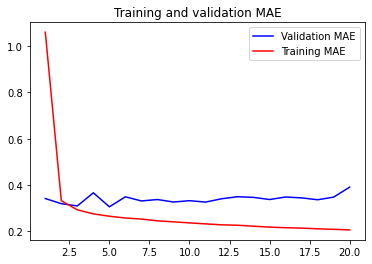

In [ ]:
# 22.8 Plot loss history
#      This function is defined at the end
plot_learning_curve()

## GRU Model

In [ ]:
###################################
### BB. GRU model
###################################

In [ ]:
# 23.1 Design model
del model
model = Sequential()

In [ ]:
# Input layer                             240                14
model.add(tf.keras.Input(shape = (lookback // step, float_data.shape[-1])))

In [ ]:
# 23.2 Add a Gated Recurrent Unit layer (similar to LSTM)
#      Input sequence has 240 values
model.add(
          tf.keras.layers.GRU(
                               32
                              )
         )

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                4608      
                                                                 
Total params: 4,608
Trainable params: 4,608
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 23.3 Output layer
model.add(layers.Dense(1))

# 23.4 How does model look like?
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                4608      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


### Our model

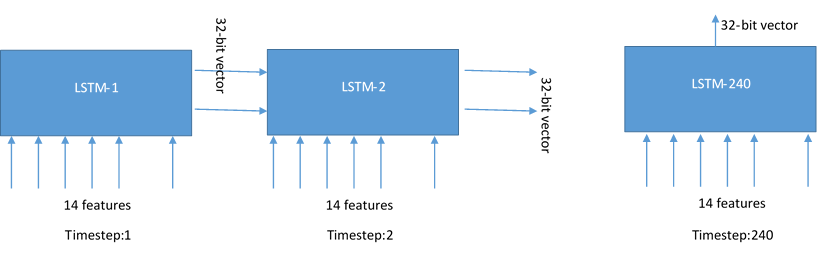

In [ ]:
# 23.5 Compile the model
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
# 23.6 Train the model
# Refer: https://stackoverflow.com/a/44277785
start = time.time()    # Takes 10 minutes
history = model.fit_generator(train_gen,    # Each time train_gen is called, it
                                            #  returns a sample of shape (128,240,14)
                                            #   So 240 GRU units, each receiving
                                            #    input vector of 14 features (Xt)
                                            #     Size of each timeseries: 240. Total batches: 128
                              steps_per_epoch=50,  # Total number of times generator called
                                                   #   & samples yielded from generator
                                                   #     Here each step brings a batch of 128
                              epochs=20,    # What is an epoch? An epoch finishes
                                           #  when steps_per_epoch batches have
                                           #    been seen by the model.
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose =1)

end = time.time()
print((end-start)/60)   # 2 mins on colab

Epoch 1/20


<ipython-input-71-2d30b09b3e98>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,    # Each time train_gen is called, it


50/50 [==============================] - 10s 109ms/step - loss: 0.3843 - val_loss: 0.3131
Epoch 2/20
50/50 [==============================] - 4s 80ms/step - loss: 0.3224 - val_loss: 0.2801
Epoch 3/20
50/50 [==============================] - 4s 83ms/step - loss: 0.3195 - val_loss: 0.3052
Epoch 4/20
50/50 [==============================] - 5s 103ms/step - loss: 0.3140 - val_loss: 0.2765
Epoch 5/20
50/50 [==============================] - 5s 105ms/step - loss: 0.3139 - val_loss: 0.3014
Epoch 6/20
50/50 [==============================] - 6s 114ms/step - loss: 0.3067 - val_loss: 0.2864
Epoch 7/20
50/50 [==============================] - 4s 82ms/step - loss: 0.3080 - val_loss: 0.2909
Epoch 8/20
50/50 [==============================] - 4s 78ms/step - loss: 0.3011 - val_loss: 0.2784
Epoch 9/20
50/50 [==============================] - 5s 97ms/step - loss: 0.3073 - val_loss: 0.2878
Epoch 10/20
50/50 [==============================] - 4s 88ms/step - loss: 0.3079 - val_loss: 0.3068
Epoch 11/20
50/

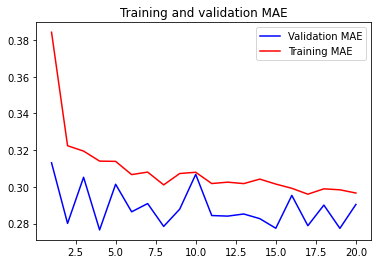

In [ ]:
# 23.7 Plot loss history
#      This function is defined at the end
plot_learning_curve()

## GRU model with dropouts

In [ ]:
###################################
### CC. GRU model with dropouts
###################################

In [ ]:
# Models with dropouts take longer time than without dropouts. Why? See:
#   https://stats.stackexchange.com/a/377126
# 24.1 Design model
del model
model = Sequential()

# 24.2 GRU layer with dropouts
#      What is Recurrent layer dropout?
#      See: https://stackoverflow.com/questions/44924690/keras-the-difference-between-lstm-dropout-and-lstm-recurrent-dropout
model.add(tf.keras.layers.GRU(32,
                     dropout=0.2,             # Dropout of input layer
                     recurrent_dropout=0.2,   # Dropout of recurrent layer
                     input_shape=(None, float_data.shape[-1]) # float_data.shape[-1] = 14
                     )
        )

In [ ]:
# 24.3 Output layer
model.add(tf.keras.layers.Dense(1))

# 24.4 Compile te model
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
# 24.5 Model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 32)                4608      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 24.6 Train the model
start = time.time()     # Around 32 minutes
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose =1)
end = time.time()
print((end-start)/60)

In [ ]:
# 24.7 Plot loss history
#      This function is defined at the end
plot_learning_curve()

## Stacked GRU Model

In [ ]:
###################################
### DD. Stacked GRU models
###     Takes long time
###################################

In [ ]:
# 25.1 Design model
model = Sequential()
# 25.2 First GRU layer
model.add(tf.keras.layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,    # Dropouts between two stacked GRU layers
                     return_sequences=True,    # Must for stacking another layer on top
                     input_shape=(None, float_data.shape[-1])))

In [ ]:
# 25.3 IInd GRU layer
model.add(tf.keras.layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5)
          )

In [ ]:
# 25.4 Final output layer
model.add(tf.keras.layers.Dense(1))
# 25.6 Compile the model
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
# 25.5 Model summary
model.summary()

In [ ]:
# 25.7 Train the model
start = time.time()    # Takes 82 minutes
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose =1
                              )
end = time.time()
print((end-start)/60)


In [ ]:
# 25.8 Plot loss history now, epoch-wise
#      This function is defined at the end
plot_learning_curve()

## BiDirectional RNN

In [ ]:
###################################
### EE. Bidirectional RNN
###     Takes long time
###################################

In [ ]:
"""
What is bidirectional RNN?
    Ref: Page: 220, Book on Deep Learning by Chollet
    A bidirectional RNN is two RNNs running in parallel
    and their outputs get concatenated to be fed to
    classifier. One RNN considers input sequence as it
    comes (this is a cow). The other RNN reverses the
    sequence (cow a is this). It looks at the sequence
    from different perspective with the hope that this
    new angle may further assist in creating new features.
    As Bidirectional RNN uses two RNNs they can be GRU
    or LSTM or even SimpleRNN.
"""

In [ ]:
# 26.1 Develop deeplearning model using bidirectioal RNN
model = Sequential()
model.add(layers.Bidirectional(
                               layers.GRU(32),      # Can use LSTMs also
                               input_shape=(None,float_data.shape[-1])
                               )
         )

In [ ]:
model.add(layers.Dense(1))
model.compile(
              optimizer = RMSprop(),
              loss = 'mae'
              )

In [ ]:
start = time.time()
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 10,
                              validation_data = val_gen,
                              validation_steps=val_steps
                              )
end = time.time()
(end-start)/60


In [ ]:

# 26.2 Plot loss history now, epoch-wise
#      This function is defined at the end
plot_learning_curve()

In [ ]:
"""
How to improve further?
Suggestions to further improve model:
    i)  Adjust the number of units in each recurrent layer in Stacked setup
        Current choice is arbitrary.
    ii) Adjust the learning rate used by RMSprop layer.
        Syntax: RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    iii)Try using LSTM layers instead of GRU layers. LSTM layers
        are computaionally intensive but retain more memory.
    iv) Try using a bigger densely connected regressor instead
        of simple one as used here.
    v)  Run the best performing model as per the history instead of
        the model that is returned at the end of all epochs.
    vi) Maybe add a convolution layer before recurrent layer
"""'